# Powerlifting Performance Trajectory Analysis

## Project Overview
This notebook analyzes the longitudinal trajectories of competitive powerlifting performance by sex, using the OpenPowerlifting dataset.

### Research Questions
1. How do male and female powerlifters' relative performances change across their competitive lifespans?
2. At what age do lifters of each sex typically achieve peak performance (normalized strength metrics)?
3. What are the differences in the rates of performance improvement and decline between male and female lifters?

### Required Packages
```
pandas==2.1.0
numpy==1.24.3
matplotlib==3.7.2
seaborn==0.12.2
statsmodels==0.14.0
scipy==1.11.2
```

---

**Note:** In this dataset, failed lift attempts are marked as negative values in the attempt columns (e.g., -330 in Deadlift3Kg means a failed third deadlift). These are set to NaN for all analyses. Only the Wilks score is available as a normalized metric.


In [2]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf

# Set plotting style
sns.set_theme(style='darkgrid')
sns.set_palette('colorblind')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Preparation & Cleaning

- Retain only Full Power (SBD) and sanctioned meets.
- Filter to non-missing Sex, Age, and Wilks.
- Convert ages to integer (floor).
- Create AgeGroup variable in 5-year bins.
- Parse Date and extract Year.
- Set failed attempts (negative values) to NaN in all attempt columns.


In [3]:
# Read the dataset
df = pd.read_csv('openpowerlifting_sampled.csv')
print("Initial dataset shape:", df.shape)

# 1. Filter for Full Power meets and sanctioned meets
df = df[df['Event'] == 'SBD']
df = df[df['MeetCountry'] != '']

# 2. Filter for non-missing Sex, Age, and Wilks
df = df.dropna(subset=['Sex', 'Age', 'Wilks'], how='any')

# 3. Convert ages to integers (floor)
df['Age'] = df['Age'].astype(int)

# 4. Create AgeGroup variable in 5-year bins
df['AgeGroup'] = pd.cut(df['Age'],
                        bins=range(0, 101, 5),
                        labels=[f'{i}-{i+4}' for i in range(0, 100, 5)])

# 5. Convert Date to datetime and extract Year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# 6. Set failed attempts (negative values) to NaN in all attempt columns
attempt_cols = [
    'Squat1Kg', 'Squat2Kg', 'Squat3Kg',
    'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
    'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg'
]
for col in attempt_cols:
    df[col] = df[col].apply(lambda x: np.nan if pd.notnull(x) and x < 0 else x)

print("Cleaned dataset shape:", df.shape)
print("\nAge groups distribution:")
print(df['AgeGroup'].value_counts().sort_index())

Initial dataset shape: (10000, 37)
Cleaned dataset shape: (7514, 39)

Age groups distribution:
AgeGroup
0-4         0
5-9        12
10-14     278
15-19    1394
20-24    1840
25-29    1267
30-34     782
35-39     592
40-44     503
45-49     341
50-54     220
55-59     116
60-64      82
65-69      51
70-74      25
75-79      10
80-84       1
85-89       0
90-94       0
95-99       0
Name: count, dtype: int64


## 2. Descriptive Statistics

- Compute summary tables of mean, median, SD of Wilks by Sex and AgeGroup.
- Output a table of sample sizes per sex �� age group.


In [4]:
# Summary statistics for Wilks by Sex and AgeGroup
summary = df.groupby(['Sex', 'AgeGroup'])['Wilks'].agg(['mean', 'median', 'std']).round(2)
summary.to_csv('summary_wilks.csv')
print("\nSummary statistics for Wilks score:")
print(summary)

# Sample size table
sample_sizes = df.groupby(['Sex', 'AgeGroup']).size().unstack(fill_value=0)
sample_sizes.to_csv('sample_sizes.csv')
print("\nSample sizes by Sex and AgeGroup:")
print(sample_sizes)


Summary statistics for Wilks score:
                mean  median    std
Sex AgeGroup                       
F   0-4          NaN     NaN    NaN
    5-9       203.12  194.93  43.50
    10-14     254.14  249.19  57.19
    15-19     303.75  300.58  57.27
    20-24     332.90  331.40  59.33
    25-29     331.52  328.67  63.22
    30-34     322.62  319.29  62.07
    35-39     319.36  313.72  62.04
    40-44     310.30  306.74  60.96
    45-49     297.14  292.12  63.96
    50-54     289.43  282.77  57.17
    55-59     251.96  250.51  44.88
    60-64     255.99  243.08  59.34
    65-69     215.09  230.03  39.18
    70-74     244.79  240.97  52.75
    75-79     185.08  185.08  24.44
    80-84        NaN     NaN    NaN
    85-89        NaN     NaN    NaN
    90-94        NaN     NaN    NaN
    95-99        NaN     NaN    NaN
M   0-4          NaN     NaN    NaN
    5-9       185.47  202.98  49.35
    10-14     249.26  248.94  58.95
    15-19     342.82  345.76  55.44
    20-24     374.69  374.2

/var/folders/92/8b71n6kj0h33ch61yv1mfqxw0000gn/T/ipykernel_52285/3511919412.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['Sex', 'AgeGroup'])['Wilks'].agg(['mean', 'median', 'std']).round(2)
/var/folders/92/8b71n6kj0h33ch61yv1mfqxw0000gn/T/ipykernel_52285/3511919412.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = df.groupby(['Sex', 'AgeGroup']).size().unstack(fill_value=0)


## 3. Time-series & Peak Performance Identification

- For each lifter, calculate their career trajectory by ordering their meets by Date.
- Aggregate at the sex �� age level: calculate median Wilks at each exact age for M and F.
- Identify the age at which median Wilks peaks for each sex.


In [5]:
# Calculate career trajectories
career_trajectories = df.sort_values(['Name', 'Date']).groupby('Name')

# Median Wilks by sex and exact age
age_medians = df.groupby(['Sex', 'Age'])['Wilks'].median().reset_index()

# Find peak ages
peak_ages = age_medians.groupby('Sex').apply(lambda x: x.loc[x['Wilks'].idxmax()])
print("\nPeak performance ages (Wilks):")
print(peak_ages)


Peak performance ages (Wilks):
    Sex  Age   Wilks
Sex                 
F     F   23  338.25
M     M   33  384.71


/var/folders/92/8b71n6kj0h33ch61yv1mfqxw0000gn/T/ipykernel_52285/885651341.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_ages = age_medians.groupby('Sex').apply(lambda x: x.loc[x['Wilks'].idxmax()])


## 4. Visualizations

- Line charts: Plot median Wilks vs. age, separate lines for M and F; mark and label the peak age for each sex.
- Boxplots: For key age groups (e.g. 20-24, 30-34, 40-44), draw side-by-side boxplots of Wilks by sex.
- Career trajectories: Randomly sample 100 male and 100 female lifters and overlay their individual trajectories (thin, low-alpha lines) beneath the group median curves.


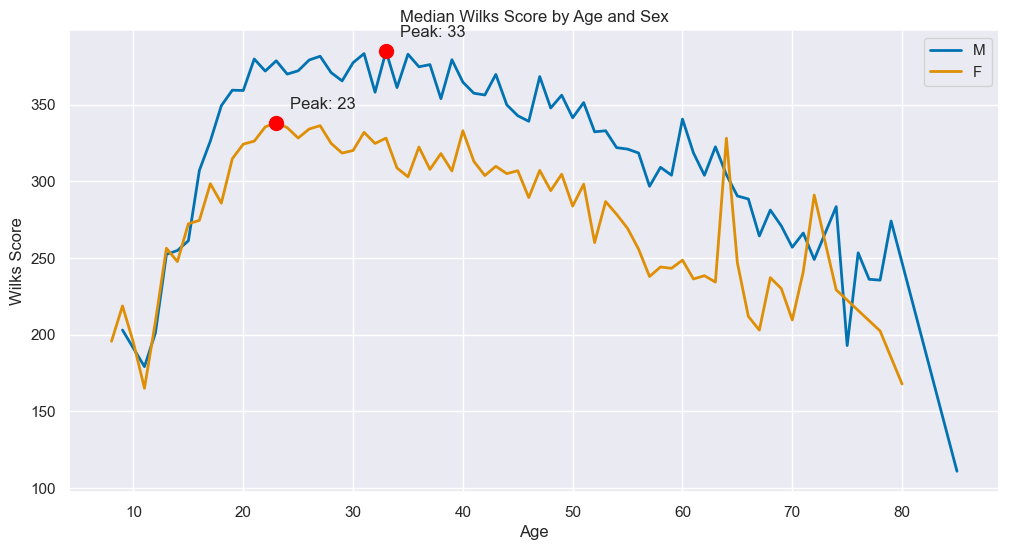

In [6]:
# 4.1 Line chart of median Wilks vs age by sex
plt.figure(figsize=(12, 6))
for sex in ['M', 'F']:
    sex_data = age_medians[age_medians['Sex'] == sex]
    plt.plot(sex_data['Age'], sex_data['Wilks'], label=sex, linewidth=2)
    # Mark peak age
    peak_age = peak_ages.loc[sex, 'Age']
    peak_wilks = peak_ages.loc[sex, 'Wilks']
    plt.scatter(peak_age, peak_wilks, color='red', s=100, zorder=5)
    plt.annotate(f'Peak: {peak_age}', xy=(peak_age, peak_wilks), xytext=(10, 10), textcoords='offset points')
plt.title('Median Wilks Score by Age and Sex')
plt.xlabel('Age')
plt.ylabel('Wilks Score')
plt.legend()
plt.grid(True)
plt.savefig('wilks_by_age_sex.png', dpi=300, bbox_inches='tight')
plt.show()

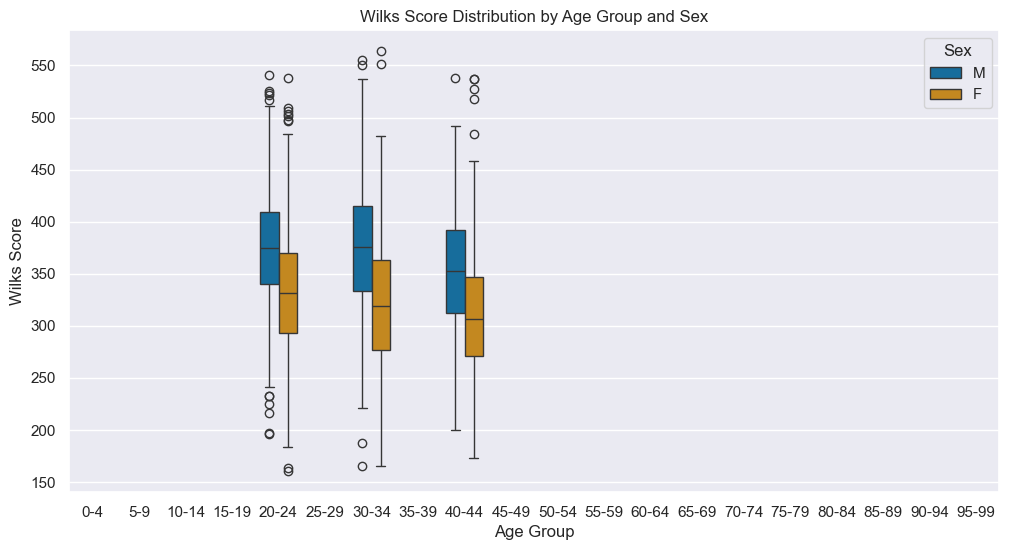

In [7]:
# 4.2 Boxplots for key age groups
key_age_groups = ['20-24', '30-34', '40-44']
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['AgeGroup'].isin(key_age_groups)], x='AgeGroup', y='Wilks', hue='Sex')
plt.title('Wilks Score Distribution by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Wilks Score')
plt.savefig('wilks_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

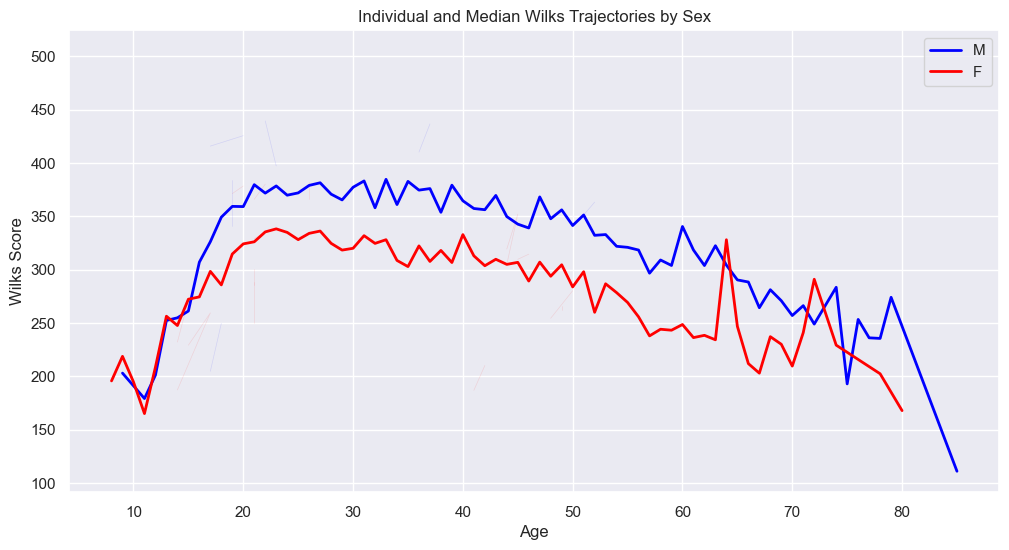

In [8]:
# 4.3 Individual trajectories
sampled_males = df[df['Sex'] == 'M']['Name'].unique()
sampled_females = df[df['Sex'] == 'F']['Name'].unique()
np.random.seed(42)
sampled_males = np.random.choice(sampled_males, min(100, len(sampled_males)), replace=False)
sampled_females = np.random.choice(sampled_females, min(100, len(sampled_females)), replace=False)
plt.figure(figsize=(12, 6))
for name in sampled_males:
    lifter_data = df[df['Name'] == name]
    plt.plot(lifter_data['Age'], lifter_data['Wilks'], color='blue', alpha=0.1, linewidth=0.5)
for name in sampled_females:
    lifter_data = df[df['Name'] == name]
    plt.plot(lifter_data['Age'], lifter_data['Wilks'], color='red', alpha=0.1, linewidth=0.5)
for sex in ['M', 'F']:
    sex_data = age_medians[age_medians['Sex'] == sex]
    plt.plot(sex_data['Age'], sex_data['Wilks'], label=sex, linewidth=2, color='blue' if sex == 'M' else 'red')
plt.title('Individual and Median Wilks Trajectories by Sex')
plt.xlabel('Age')
plt.ylabel('Wilks Score')
plt.legend()
plt.grid(True)
plt.savefig('individual_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Inferential Statistics

- T-tests: At each of three age bracket midpoints (e.g. 25, 35, 45), perform independent-samples t-tests comparing male vs. female Wilks.
- Regression analysis: Fit a linear mixed-effects model predicting Wilks from Age (continuous), Sex, and Age �� Sex interaction, with random intercepts for Name (lifter).


In [9]:
# 5.1 T-tests at key age brackets
key_ages = [25, 35, 45]
t_test_results = []
for age in key_ages:
    age_range = (age - 2, age + 2)
    age_data = df[(df['Age'] >= age_range[0]) & (df['Age'] <= age_range[1])]
    male_scores = age_data[age_data['Sex'] == 'M']['Wilks']
    female_scores = age_data[age_data['Sex'] == 'F']['Wilks']
    t_stat, p_val = stats.ttest_ind(male_scores, female_scores, nan_policy='omit')
    t_test_results.append({
        'Age': age,
        't-statistic': t_stat,
        'p-value': p_val,
        'Male_mean': male_scores.mean(),
        'Female_mean': female_scores.mean()
    })
t_test_df = pd.DataFrame(t_test_results)
t_test_df.to_csv('t_test_results.csv', index=False)
print("\nT-test results at key age brackets:")
print(t_test_df)


T-test results at key age brackets:
   Age  t-statistic       p-value   Male_mean  Female_mean
0   25    13.337259  1.637517e-38  376.974910   336.441730
1   35    12.233281  3.247991e-31  379.665261   318.431134
2   45     8.130536  5.204947e-15  354.540419   306.410537


In [10]:
# 5.2 Mixed-effects model
model_data = df[['Name', 'Age', 'Sex', 'Wilks']].copy()
model_data['Sex'] = model_data['Sex'].map({'M': 0, 'F': 1})
model = smf.mixedlm('Wilks ~ Age * Sex', model_data, groups=model_data['Name'])
model_fit = model.fit()
model_summary = model_fit.summary()
with open('mixed_model_results.txt', 'w') as f:
    f.write(str(model_summary))
print("\nMixed model results:")
print(model_summary)


Mixed model results:
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Wilks      
No. Observations: 7514    Method:             REML       
No. Groups:       6996    Scale:              742.7570   
Min. group size:  1       Log-Likelihood:     -41609.0094
Max. group size:  5       Converged:          Yes        
Mean group size:  1.1                                    
---------------------------------------------------------
           Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  366.558    2.770 132.317 0.000 361.129 371.988
Age         -0.424    0.088  -4.804 0.000  -0.597  -0.251
Sex        -39.239    4.095  -9.583 0.000 -47.264 -31.214
Age:Sex     -0.063    0.129  -0.489 0.625  -0.316   0.190
Group Var 3343.474    9.328                              

